In [1]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import ipywidgets
import numpy as np
import math

In [2]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [36]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degree,dtype=np.float32) # 分配大量的空间
true_w[0:4] = np.array([5, 1.2,-3.4, 5.6],dtype=np.float32)
features = np.random.normal(size=(n_train + n_test, 1)).astype(np.float32)
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree,dtype=np.float32).reshape(1,-1))

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.4, size=labels.shape)

In [4]:
labels.reshape(-1,1).dtype

dtype('float32')

In [5]:
def evaluate_loss(net,data_iter,loss):
    metric = Accumulator(2)
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels, num_epoches=600):

    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1,bias=False))
    for i in net:
        if type(i) == nn.Linear:
            nn.init.uniform_(i.weight,-0.05,0.05)
    batch_size = min(10,train_labels.shape[0])
    train_iter = data.DataLoader(list(zip(train_features,train_labels.reshape(-1,1))),batch_size,shuffle=True)
    test_iter = data.DataLoader(list(zip(test_features,test_labels.reshape(-1,1))),batch_size,shuffle=True)

    trainer = torch.optim.SGD(net.parameters(),lr=0.01)

    progress_bar = ipywidgets.IntProgress(value=0,min=0,max=(num_epoches-1))
    display(progress_bar)

    train_metrics = []

    for epoch in range(num_epoches):
        for X,y in train_iter:
            out = net(X)
            net.zero_grad()
            l = loss(out, y)
            l.backward()
            trainer.step()
        train_loss = evaluate_loss(net,train_iter,loss)
        test_loss = evaluate_loss(net,test_iter,loss)
        train_metrics.append((train_loss,test_loss))
        progress_bar.value = epoch
    print(net[0].weight.data.numpy())
    print(true_w)
    return train_metrics


In [37]:
train_metrics = train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])

IntProgress(value=0, max=599)

[[ 5.002049   1.3044599 -3.42369    5.3745255]]
[ 5.   1.2 -3.4  5.6  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0. ]


(100.0, 600.0)

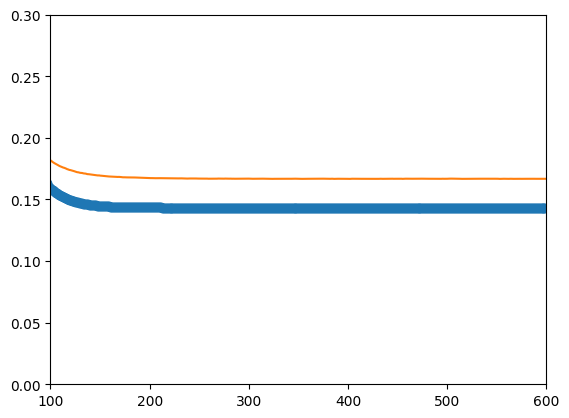

In [38]:
fig,ax=plt.subplots()
ax.plot(range(len(train_metrics)),[i[0] for i in train_metrics],'o')
ax.plot(range(len(train_metrics)),[i[1] for i in train_metrics])
ax.set_ylim(0,0.3)
ax.set_xlim(100,600)

In [39]:
overfitting = train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:])

IntProgress(value=0, max=599)

[[ 5.0019145e+00  1.4522514e+00 -3.3869770e+00  4.6610904e+00
  -1.2076455e-01  1.7221483e+00  1.3653140e-01  3.0010760e-01
   3.8755689e-02  6.7558937e-02  2.6731862e-02  4.9397264e-02
   4.1051827e-02 -8.7011391e-03 -3.9171398e-02  4.6435811e-02
   2.4367437e-02  7.6162303e-03 -4.7895283e-02 -1.1543032e-03]]
[ 5.   1.2 -3.4  5.6  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0. ]


(50.0, 600.0)

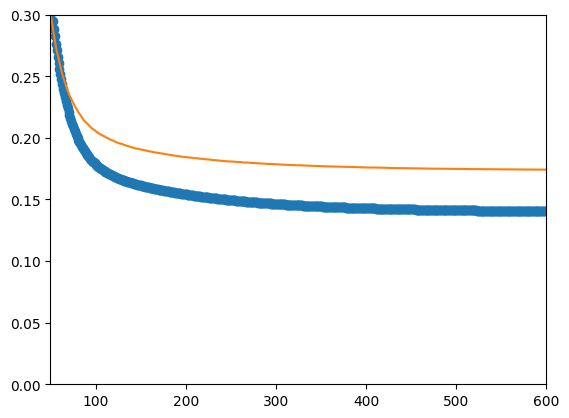

In [40]:
fig,ax=plt.subplots()
ax.plot(range(len(overfitting)),[i[0] for i in overfitting],'o')
ax.plot(range(len(overfitting)),[i[1] for i in overfitting])
ax.set_ylim(0,0.3)
ax.set_xlim(50,600)